# Overview of best week for each kage

In notebook 04 we selected the best week for each kage and extracted the most reliable keypoint ("bodycenter").

In this notebook we will explore that best week for each kage by generating the following plots:


In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from movement.kinematics import compute_speed
from movement.plots import plot_occupancy
from movement.transforms import scale
from tqdm import tqdm

from smart_kages_movement.plots import plot_speed, plot_trajectory

## Configuration
Define some global variables and paths.

In [2]:
PIXELS_PER_CM = 10  # pixels per centimeter (need to double-check this value)

# Configure seaborn for prettier plots
sns.set_context("notebook")
sns.set_style("ticks")

# Xarray display option
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False);

Define paths to the `movement_analysis` directory and relevant files.

In [3]:
project_dir = Path("/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs")
analysis_dir = project_dir / "movement_analysis"
assert analysis_dir.exists(), f"Path does not exist: {analysis_dir}"

best_week_dir = analysis_dir / "bodycenter_best_week"
best_week_file = best_week_dir / "bodycenter_best_week.nc"
assert best_week_file.exists(), f"Path does not exist: {best_week_file}"

qc_file = analysis_dir / "QC_keep.tsv"
assert qc_file.exists(), f"Path does not exist: {qc_file}"

## Load QC results with kept kages

In [4]:
# Columns containing dates
date_columns = [
    "kage_start_date",
    "good_dates_start",
    "good_dates_end",
    "analysis_start_date",
    "analysis_end_date",
]

# Load QC results
qc_df = pd.read_csv(
    qc_file,
    sep="\t",
    index_col=0,
    parse_dates=date_columns,
)

qc_df.head()

,kage_start_date,keep,keypoint,good_dates_start,good_dates_end,analysis_start_date,analysis_end_date,best_days_by_loukia,comments,data_file
kage,,,,,,,,,,
1,2024-04-02,True,bodycenter,2024-04-09,2024-05-06,2024-04-13,2024-04-20,"13-19/4, 21-28/4, 30/4-07/05",Cage looks slightly warped - can't see the cor...,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
2,2024-04-02,True,bodycenter,2024-04-13,2024-04-29,2024-04-19,2024-04-26,19-29/04 (but 13/4 is not terrible - talk to N...,video quality quite bad,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
3,2024-04-02,True,bodycenter,2024-04-15,2024-05-06,2024-04-19,2024-04-26,13-25/04,Have a look at the number of frames,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
4,2024-04-02,True,bodycenter,2024-04-19,2024-05-07,2024-04-19,2024-04-26,"19-26/04, 27/04-06/05",NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
5,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-29,2024-05-06,21/4-25/4 and 29/04-06/05,have some missimg frames 26-28/04,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...


## Load selected best week data
We will load the combined netcdf file that contains the best week for each kage.

In [5]:
ds = xr.open_dataset(best_week_file)
ds

<xarray.Dataset> Size: 774MB
Dimensions:          (time: 1209601, space: 2, keypoints: 1, individuals: 26)
Coordinates:
  * time             (time) datetime64[ns] 10MB 1970-01-01 ... 1970-01-08
  * space            (space) <U1 8B 'x' 'y'
  * keypoints        (keypoints) <U10 40B 'bodycenter'
  * individuals      (individuals) <U6 624B 'kage1' 'kage2' ... 'kage33'
    seconds_elapsed  (time) float64 10MB ...
Data variables:
    position         (time, space, keypoints, individuals) float64 503MB ...
    confidence       (time, keypoints, individuals) float64 252MB ...
Attributes: (7)

## Compute speed in units of cm/sec

- We first set the time index to "seconds_elapsed" to ensure that the
`compute_speed` and `scale` functions work correctly.
- We the scale the filtered position values to cm/sec using the `scale` function. The correctness of speed values depends on the `PIXELS_PER_CM` constant.
- We then compute the speed using the `compute_speed` function, based on the fitlered and scaled position values.
- Finally, we set the time index back to datetime.

The computed speed is stored as a new `speed` variable in the same dataset.

In [6]:
speed_cm_per_sec = compute_speed(
    scale(
        ds.position.set_index(time="seconds_elapsed"),
        factor=1 / PIXELS_PER_CM,
        space_unit="cm",
    )
)
ds["speed"] = speed_cm_per_sec.assign_coords(time=ds.time)
ds["speed"].attrs["units"] = "cm/s"

In [7]:
ds.speed

<xarray.DataArray 'speed' (time: 1209601, keypoints: 1, individuals: 26)> Size: 252MB
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * time             (time) datetime64[ns] 10MB 1970-01-01 ... 1970-01-08
  * keypoints        (keypoints) <U10 40B 'bodycenter'
  * individuals      (individuals) <U6 624B 'kage1' 'kage2' ... 'kage33'
    seconds_elapsed  (time) float64 10MB 0.0 0.5 1.0 ... 6.048e+05 6.048e+05
Attributes: (1)

## Plot combined speed data

We plot speed across kages both as a histogram and as a heatmap over time.


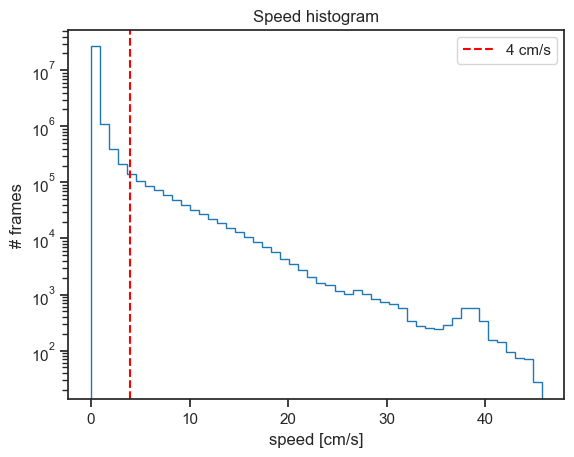

In [8]:
# Plot speed histogram
speed = ds.speed.sel(keypoints="bodycenter")

speed_threshold = 4

fig_hist, ax_hist = plt.subplots()
speed.plot.hist(bins=50, ax=ax_hist, histtype="step", label="")

ax_hist.axvline(speed_threshold, linestyle="--", color="red", label="4 cm/s")


ax_hist.set_title("Speed histogram")
ax_hist.set_yscale("log")
ax_hist.set_ylabel("# frames")
ax_hist.legend()
plt.show()

speed_hist_path = best_week_dir / "speed_histogram.png"
fig_hist.savefig(speed_hist_path, dpi=128)

What % of time is spent non-stationary (speed > 4 cm/sec)?

In [22]:
valid_frames = speed.notnull().sum()
high_speed_frames = (speed > speed_threshold).sum()
percent_high_speed = float(high_speed_frames / valid_frames * 100)

print(
    f"Frames > {speed_threshold} cm/s: "
    f"{high_speed_frames.item()} / {valid_frames.item()} "
    f"({percent_high_speed:.4f}% of valid frames)"
)

Frames > 4 cm/s: 686382 / 29037467 (2.3638% of valid frames)


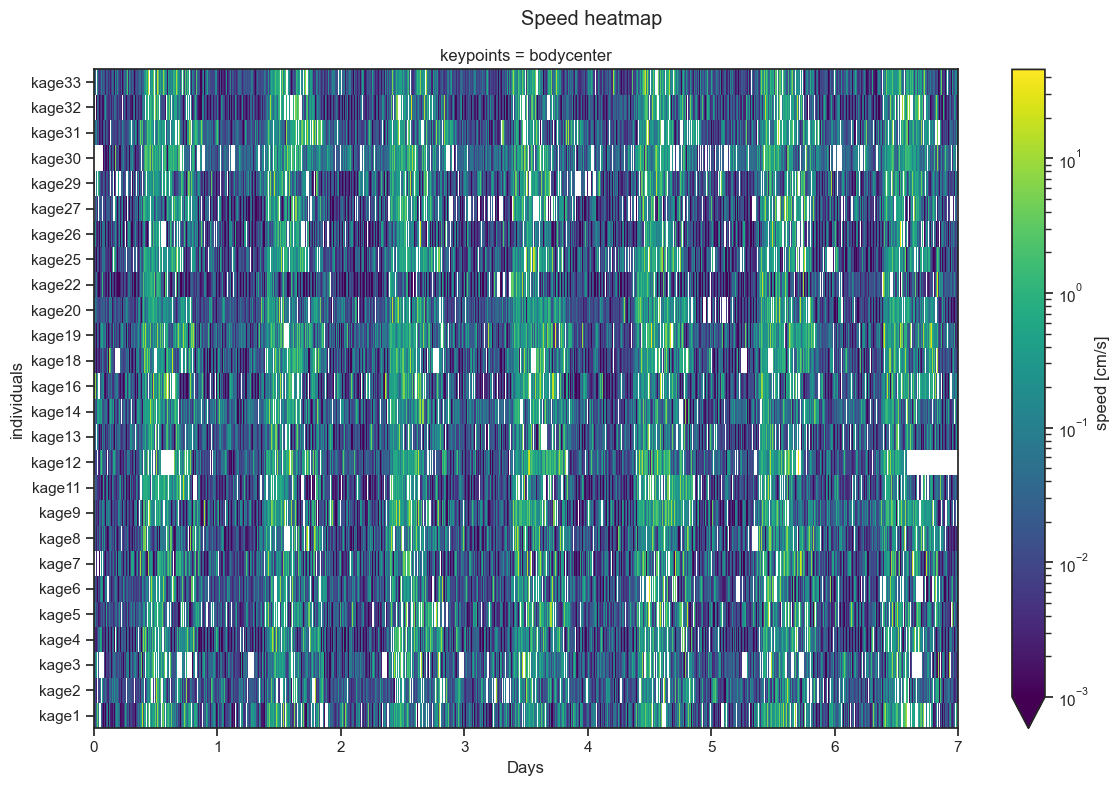

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

speed = ds.speed.sel(keypoints="bodycenter")

# Use a logarithmic colormap; set vmin>0 to avoid log(0)
speed.plot.pcolormesh(
    x="time",
    y="individuals",
    yincrease=True,
    ax=ax,
    cmap="viridis",
    norm=LogNorm(vmin=max(speed.min().item(), 1e-3)),
)

# Replace xtick labels with number of days since start
week_start, week_end = ds.time.min().item(), ds.time.max().item()
daily_ticks = pd.date_range(start=week_start, end=week_end, freq="D")
daily_tick_labels = [
    int((pd.Timestamp(tick) - pd.Timestamp(week_start)).days) for tick in daily_ticks
]
ax.set_xticks(daily_ticks)
ax.set_xticklabels(daily_tick_labels)
ax.set_xlabel("Days")
ax.set_ylim(-0.5, len(ds.individuals) - 0.5)
plt.suptitle("Speed heatmap")
plt.tight_layout()

speed_hist_path = best_week_dir / "speed_heatmap.png"
fig.savefig(speed_hist_path, dpi=128)

## Plot speed time series per individual

First let's plot speed across all 7 days of a kage, and then per day.

In [32]:
for kage in tqdm(ds.individuals.values, total=ds.sizes["individuals"]):
    # Before plotting, we will add back the real start date
    kage_id = int(kage.replace("kage", ""))  # extract number from kage string
    kage_week_start = qc_df.loc[kage_id, "analysis_start_date"]
    new_time_coords = pd.to_datetime(ds.time.values) + (
        kage_week_start - ds.time.values[0]
    )
    speed_kage = speed.sel(individuals=kage).assign_coords(time=new_time_coords)

    # Save overall speed plot
    speed_kage_plot_path = best_week_dir / kage / f"{kage}_speed.png"
    plot_speed(
        speed_kage,
        save_path=speed_kage_plot_path,
    )

    # Save daily speed plots
    for date, day_speed in speed_kage.groupby("time.date"):
        # The last date is just the midnight of the next day; skip it
        if date == speed_kage.time.dt.date.values[-1]:
            continue
        day_speed_plot_path = best_week_dir / kage / f"{kage}_{date}_speed.png"
        plot_speed(
            day_speed,
            save_path=day_speed_plot_path,
        )

    # Close all figures to avoid memory issues
    plt.close("all")

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [01:20<00:00,  3.08s/it]


## Plot trajectories and occupancy maps

We plot those per kage, for the entire week as well as per day.

The trajectories are coloured by log(speed), while the occupancy maps show log(time spent in each location).

In [18]:
TRAJECTORY_PARAMS = dict(
    s=5,
    alpha=0.5,
    cmap="turbo",
    norm="log",
    vmin=0.1,
    vmax=40,
)

OCCUPANCY_PARAMS = dict(
    alpha=0.5,
    cmap="turbo",
    norm="log",
    cmin=1,
)

100%|██████████| 26/26 [11:41<00:00, 26.96s/it]


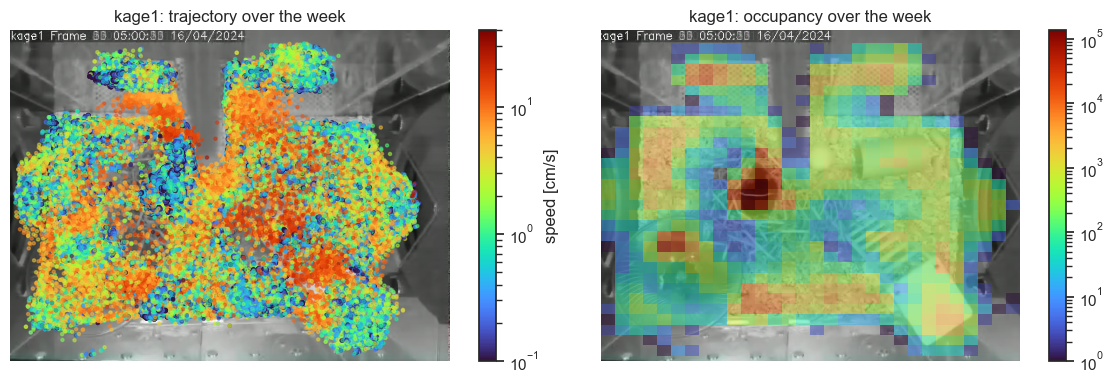

In [20]:
for kage in tqdm(ds.individuals.values, total=ds.sizes["individuals"]):
    # Load daily background images for that kage
    bg_paths = [p for p in best_week_dir.glob(f"{kage}/*_background.png")]
    bg_paths.sort()
    bg_names = [p.name for p in bg_paths]
    dates = [name.split("_")[1] for name in bg_names]
    bg_images = [plt.imread(p) for p in bg_paths]
    mid_img = bg_images[len(bg_images) // 2]  # middle image
    height, width = mid_img.shape[:2]

    # Before plotting, we will add back the real start date
    kage_id = int(kage.replace("kage", ""))
    kage_week_start = qc_df.loc[kage_id, "analysis_start_date"]
    ds_kage = ds.assign_coords(
        time=pd.to_datetime(ds.time.values) + (kage_week_start - ds.time.values[0])
    )

    # Plot for the entire week (use middle background image)
    fig_week, ax_week = plt.subplots(ncols=2, figsize=(12, 4))

    for ax in ax_week:
        ax.imshow(mid_img, extent=(0, width, height, 0))
        ax.axis("off")

    ax_week[0].set_title(f"{kage}: trajectory over the week")
    ax_week[1].set_title(f"{kage}: occupancy over the week")

    selection = dict(individuals=kage, keypoints="bodycenter")
    ds_week = ds_kage.sel(**selection).set_index(time="seconds_elapsed")

    plot_trajectory(
        ds_week.position,
        c=ds_week.speed,
        ax=ax_week[0],
        **TRAJECTORY_PARAMS,
    )

    plot_occupancy(
        ds_week.position,
        ax=ax_week[1],
        **OCCUPANCY_PARAMS,
    )
    ax_week[1].set_ylim([height - 1, 0])  # invert y-axis to match the video frame

    plt.tight_layout()
    plt.savefig(best_week_dir / kage / f"{kage}_occupancy.png", dpi=128)
    if kage != "kage1":  # keep only the first figure open to avoid memory issues
        plt.close(fig_week)

    # Daily plots
    for i, date in enumerate(dates):
        fig_day, ax_day = plt.subplots(ncols=2, figsize=(12, 4))

        for ax in ax_day:
            ax.imshow(bg_images[i], extent=(0, width, height, 0))
            ax.axis("off")
        ax_day[0].set_title(f"{kage}: trajectory on {date}")
        ax_day[1].set_title(f"{kage}: occupancy on {date}")

        selection = {
            **selection,
            "time": slice(
                pd.Timestamp(date),
                pd.Timestamp(date) + pd.Timedelta(days=1),
            ),
        }
        ds_day = ds_kage.sel(**selection).set_index(time="seconds_elapsed")

        plot_trajectory(
            ds_day.position,
            c=ds_day.speed,
            ax=ax_day[0],
            **TRAJECTORY_PARAMS,
        )

        plot_occupancy(
            ds_day.position,
            ax=ax_day[1],
            **OCCUPANCY_PARAMS,
        )
        ax_day[1].set_ylim([height - 1, 0])  # invert y-axis to match the video frame

        plt.tight_layout()
        plt.savefig(best_week_dir / kage / f"{kage}_{date}_occupancy.png", dpi=128)
        plt.close(fig_day)